Extra evaluation of `..` to make sure the evaluator is doing its job.

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import mplhep as hep
hep.style.use(hep.style.CMS)

In [2]:
REAL_LABEL = 1
FAKE_LABEL = 0
OUT_DIM = 4

n_epoch = 100

lr = 1e-3
batch_size_ev = 16



name = "qgan-3.2.3.1-s3"

save_folder = f"saved/{name}"

data_sample_path = os.path.join(save_folder,"samples.npz")

In [3]:
device = torch.device("cpu")

In [4]:
with np.load(data_sample_path) as data:
    real_samples = data["real_samples"]
    fake_samples = data["fake_samples"]

In [5]:
samples = np.concatenate((real_samples, fake_samples))

real_labels = np.repeat(REAL_LABEL, real_samples.shape[0])
fake_labels = np.repeat(FAKE_LABEL, fake_samples.shape[0])
labels = np.concatenate((real_labels, fake_labels))

X_train, X_rest, y_train, y_rest = train_test_split(
    samples, labels, train_size = 0.6, shuffle = True, stratify = labels
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_rest, y_rest, test_size = 0.5, shuffle = True, stratify = y_rest
)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_valid = torch.tensor(X_valid, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
y_valid = torch.tensor(y_valid, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)


data_loader_ev = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size = batch_size_ev, shuffle = True)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 2.0)
        m.bias.data.uniform_(-1.0, 1.0)
    elif classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# train a standalone discriminator to evaluate the performance of the GAN "objectively"
class Evaluator1(nn.Module):
    def __init__(self):
        super(Evaluator1, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 16),
            # nn.LeakyReLU(0.2),
            # nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [7]:
netEv1 = Evaluator1().to(device)
netEv1.apply(weights_init)

optimizer_ev = optim.Adam(netEv1.parameters(), lr=lr, betas=(0.5, 0.999))
loss_ev = nn.BCELoss()
print(netEv1)

Evaluator1(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [8]:
valid_losses = []
train_losses = []
iters = 0

netEv1.train()
 

print("Starting the training loop")
for epoch in range(n_epoch):
    for i, data in enumerate(data_loader_ev):
        netEv1.zero_grad()
        X_batch = data[0].to(device)
        y_batch = data[1].to(device)
        prediction_batch = netEv1(X_batch).view(-1)
        err = loss_ev(prediction_batch, y_batch)
        err.backward()
        optimizer_ev.step()

        if i%50 == 0:
            netEv1.eval()
            with torch.no_grad():
                prediction_valid = netEv1(X_valid).view(-1)
                prediction_train = netEv1(X_train).view(-1)
            train_loss = loss_ev(prediction_train, y_train).item()
            valid_loss = loss_ev(prediction_valid, y_valid).item()
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_acc  = torch.isclose(torch.round(prediction_valid), y_valid).sum().item()/len(y_valid)
            netEv1.train()

            print(
                f"[{epoch}/{n_epoch}][{i}/{len(data_loader_ev)}]\tLoss train: {train_loss:.3f}\tLoss valid: {valid_loss:.3f}\tLoss acc: {valid_acc:.3f}"
            )

Starting the training loop
[0/100][0/750]	Loss train: 13.662	Loss valid: 13.757	Loss acc: 0.526
[0/100][50/750]	Loss train: 7.093	Loss valid: 7.158	Loss acc: 0.526
[0/100][100/750]	Loss train: 2.359	Loss valid: 2.392	Loss acc: 0.451
[0/100][150/750]	Loss train: 1.236	Loss valid: 1.266	Loss acc: 0.526
[0/100][200/750]	Loss train: 1.144	Loss valid: 1.172	Loss acc: 0.527
[0/100][250/750]	Loss train: 1.012	Loss valid: 1.037	Loss acc: 0.527
[0/100][300/750]	Loss train: 0.933	Loss valid: 0.956	Loss acc: 0.526
[0/100][350/750]	Loss train: 0.840	Loss valid: 0.860	Loss acc: 0.527
[0/100][400/750]	Loss train: 0.803	Loss valid: 0.821	Loss acc: 0.527
[0/100][450/750]	Loss train: 0.777	Loss valid: 0.793	Loss acc: 0.576
[0/100][500/750]	Loss train: 0.769	Loss valid: 0.784	Loss acc: 0.576
[0/100][550/750]	Loss train: 0.751	Loss valid: 0.765	Loss acc: 0.576
[0/100][600/750]	Loss train: 0.742	Loss valid: 0.756	Loss acc: 0.576
[0/100][650/750]	Loss train: 0.742	Loss valid: 0.756	Loss acc: 0.576
[0/100][

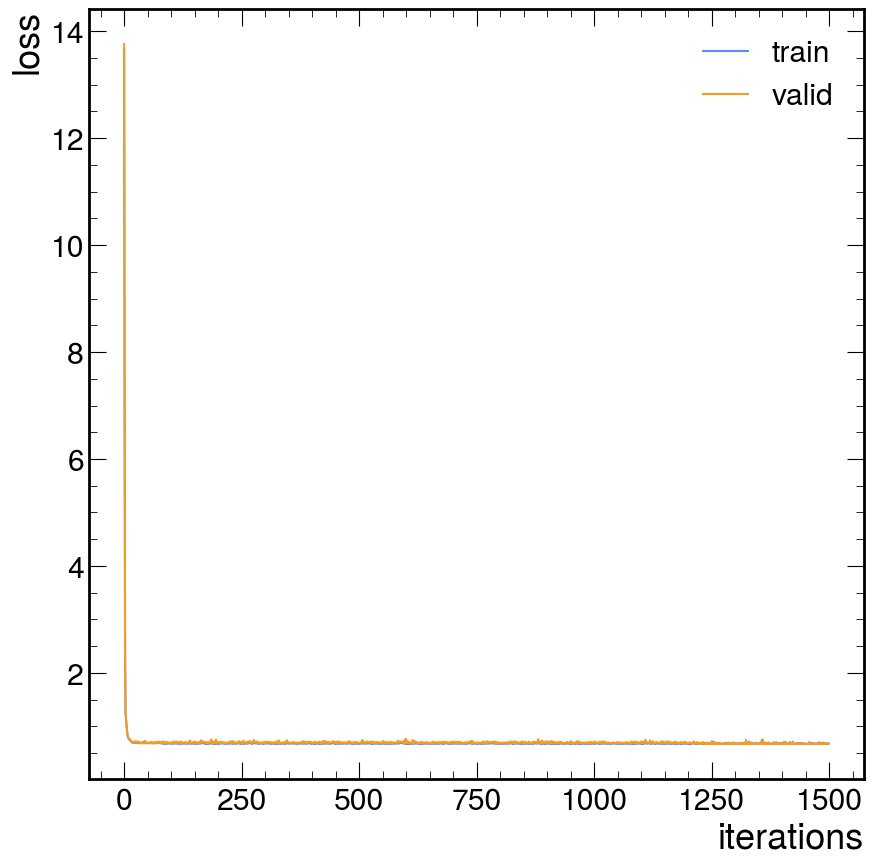

In [9]:
fig, ax = plt.subplots()
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.set(xlabel="iterations", ylabel="loss")
ax.legend()

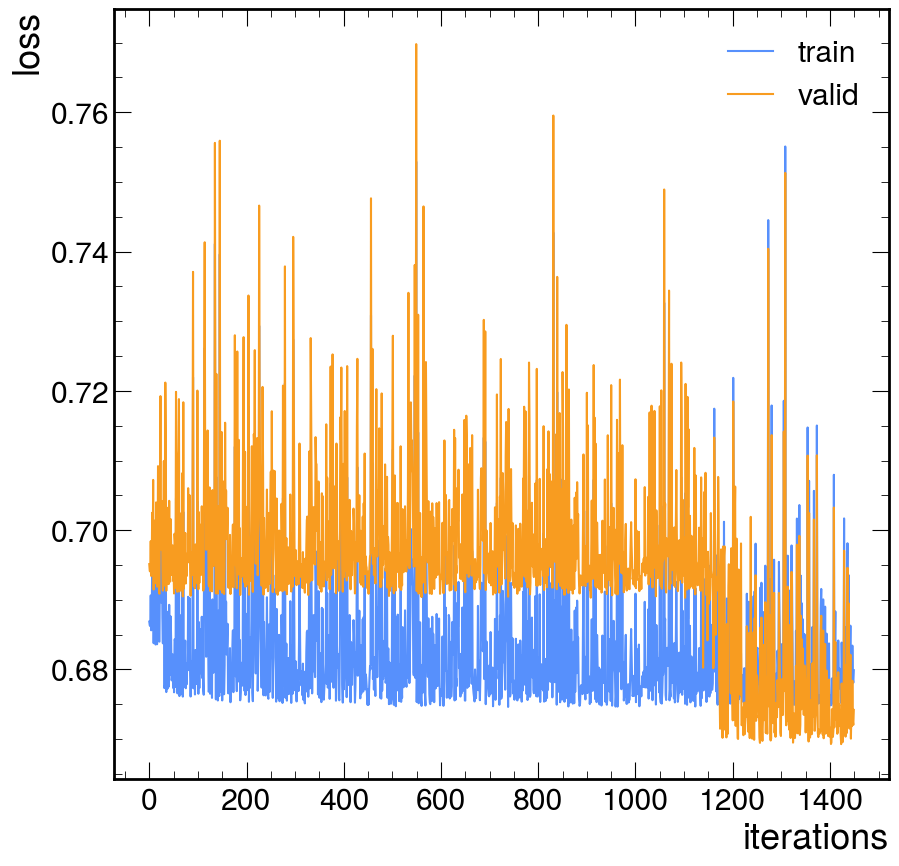

In [10]:
fig, ax = plt.subplots()
ax.plot(train_losses[50:], label="train")
ax.plot(valid_losses[50:], label="valid")
ax.set(xlabel="iterations", ylabel="loss")
ax.legend()

In [11]:
netEv1.eval()

with torch.no_grad():
    prediction_test = netEv1(X_test).view(-1)

test_acc = torch.isclose(torch.round(prediction_test), y_test).sum().item() / len(y_test)

print(f"Test accuracy: {test_acc}")

Test accuracy: 0.59275


In [12]:
print(f"AUC score is {roc_auc_score(y_test, prediction_test)}")

AUC score is 0.622952


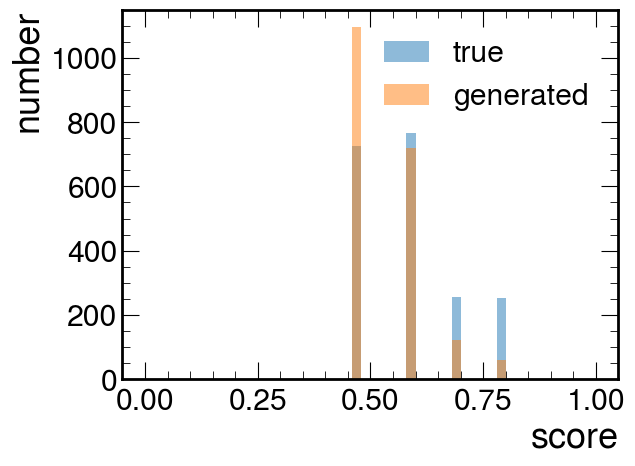

In [13]:
true_indices = y_test.isclose(torch.tensor(1.0))
fake_indices = y_test.isclose(torch.tensor(0.0))

pred_true = prediction_test[true_indices]
pred_fake = prediction_test[fake_indices]

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.hist(pred_true.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha=0.5, label="true")
ax.hist(pred_fake.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha=0.5, label="generated")
ax.legend()
ax.set(xlabel="score", ylabel="number")


None

In [14]:
# # train a standalone discriminator to evaluate the performance of the GAN "objectively"
# class Evaluator2(nn.Module):
#     def __init__(self):
#         super(Evaluator2, self).__init__()
#         self.main = nn.Sequential(
#             nn.Linear(OUT_DIM, 16),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.1),
#             nn.Linear(16, 16),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.1),
#             nn.Linear(16, 8),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.1),
#             nn.Linear(8, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, input):
#         return self.main(input)

# train a standalone discriminator to evaluate the performance of the GAN "objectively"
class Evaluator2(nn.Module):
    def __init__(self):
        super(Evaluator2, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 16),
            # nn.LeakyReLU(0.2),
            # nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.2),
            nn.Linear(16, 6),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.2),
            nn.Linear(6, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [15]:
netEv2 = Evaluator2().to(device)
netEv2.apply(weights_init)

optimizer_ev = optim.Adam(netEv2.parameters(), lr=lr, betas=(0.5, 0.999))
loss_ev = nn.BCELoss()
print(netEv2)

Evaluator2(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=16, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [16]:
valid_losses = []
train_losses = []
iters = 0

netEv2.train()
 

print("Starting the training loop")
for epoch in range(n_epoch):
    for i, data in enumerate(data_loader_ev):
        netEv2.zero_grad()
        X_batch = data[0].to(device)
        y_batch = data[1].to(device)
        prediction_batch = netEv2(X_batch).view(-1)
        err = loss_ev(prediction_batch, y_batch)
        err.backward()
        optimizer_ev.step()

        if i%50 == 0:
            netEv2.eval()
            with torch.no_grad():
                prediction_valid = netEv2(X_valid).view(-1)
                prediction_train = netEv2(X_train).view(-1)
            train_loss = loss_ev(prediction_train, y_train).item()
            valid_loss = loss_ev(prediction_valid, y_valid).item()
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_acc  = torch.isclose(torch.round(prediction_valid), y_valid).sum().item()/len(y_valid)
            netEv1.train()

            print(
                f"[{epoch}/{n_epoch}][{i}/{len(data_loader_ev)}]\tLoss train: {train_loss:.3f}\tLoss valid: {valid_loss:.3f}\tLoss acc: {valid_acc:.3f}"
            )

Starting the training loop
[0/100][0/750]	Loss train: 10.084	Loss valid: 9.929	Loss acc: 0.574
[0/100][50/750]	Loss train: 5.792	Loss valid: 5.886	Loss acc: 0.575
[0/100][100/750]	Loss train: 3.660	Loss valid: 3.718	Loss acc: 0.575
[0/100][150/750]	Loss train: 3.593	Loss valid: 3.650	Loss acc: 0.574
[0/100][200/750]	Loss train: 3.619	Loss valid: 3.679	Loss acc: 0.574
[0/100][250/750]	Loss train: 3.572	Loss valid: 3.632	Loss acc: 0.574
[0/100][300/750]	Loss train: 3.574	Loss valid: 3.636	Loss acc: 0.500
[0/100][350/750]	Loss train: 3.564	Loss valid: 3.627	Loss acc: 0.574
[0/100][400/750]	Loss train: 3.556	Loss valid: 3.622	Loss acc: 0.575
[0/100][450/750]	Loss train: 3.547	Loss valid: 3.615	Loss acc: 0.575
[0/100][500/750]	Loss train: 3.542	Loss valid: 3.610	Loss acc: 0.498
[0/100][550/750]	Loss train: 3.525	Loss valid: 3.596	Loss acc: 0.574
[0/100][600/750]	Loss train: 3.560	Loss valid: 3.635	Loss acc: 0.574
[0/100][650/750]	Loss train: 3.503	Loss valid: 3.579	Loss acc: 0.574
[0/100][7

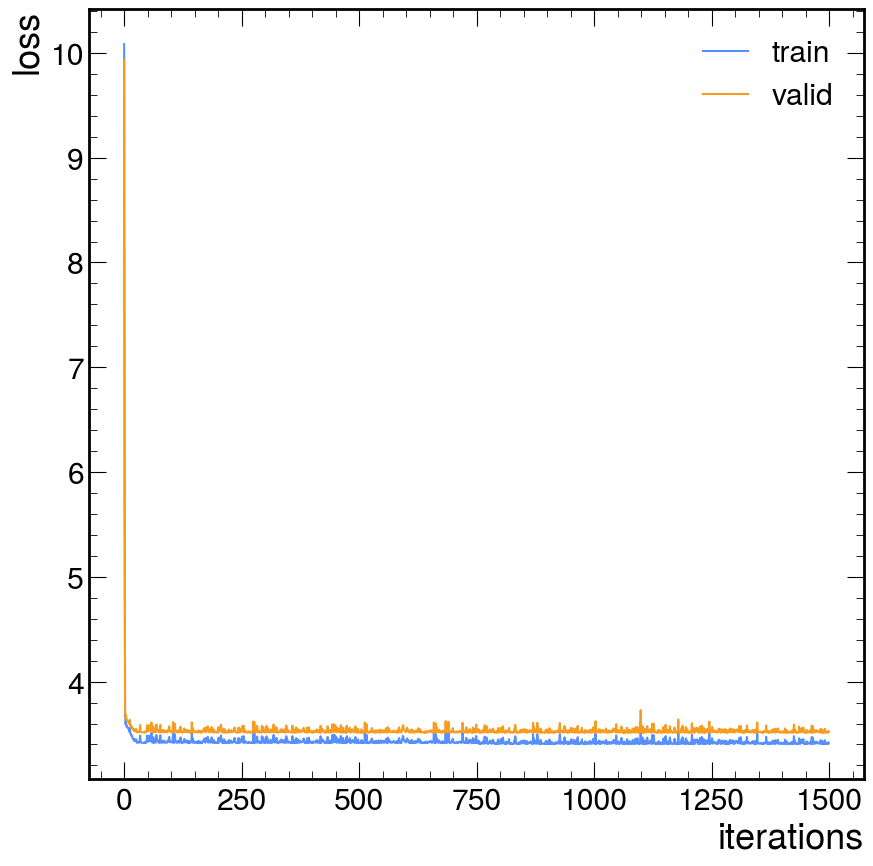

In [17]:
fig, ax = plt.subplots()
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.set(xlabel="iterations", ylabel="loss")
ax.legend()

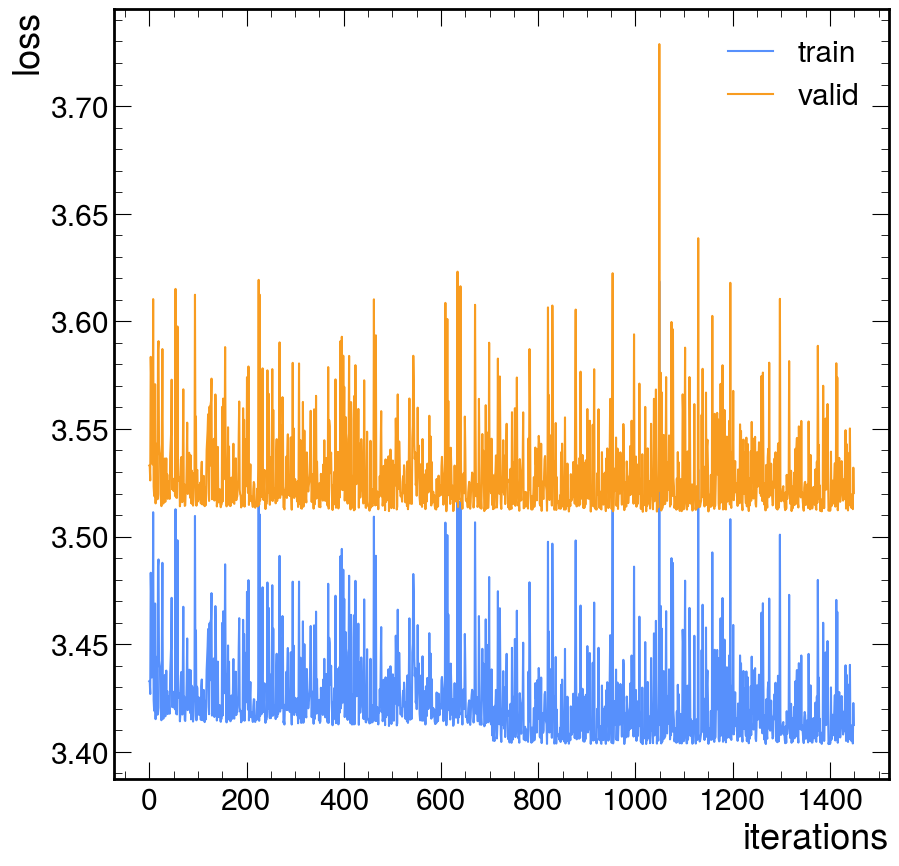

In [18]:
fig, ax = plt.subplots()
ax.plot(train_losses[50:], label="train")
ax.plot(valid_losses[50:], label="valid")
ax.set(xlabel="iterations", ylabel="loss")
ax.legend()

In [19]:
netEv2.eval()

with torch.no_grad():
    prediction_test = netEv2(X_test).view(-1)

test_acc = torch.isclose(torch.round(prediction_test), y_test).sum().item() / len(y_test)

print(f"Test accuracy: {test_acc}")

Test accuracy: 0.58125


In [20]:
print(f"AUC score is {roc_auc_score(y_test, prediction_test)}")

AUC score is 0.61921775


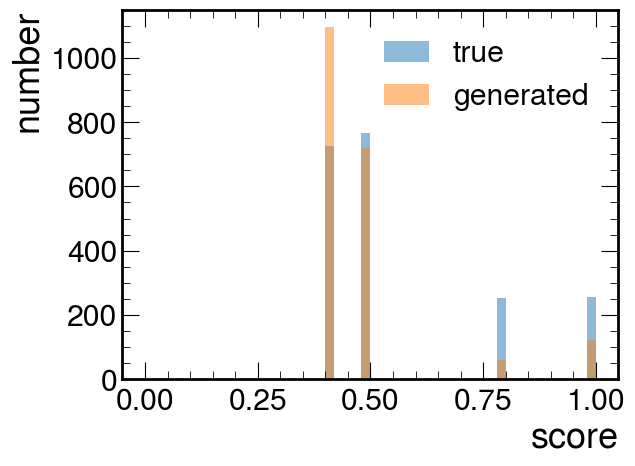

In [21]:
true_indices = y_test.isclose(torch.tensor(1.0))
fake_indices = y_test.isclose(torch.tensor(0.0))

pred_true = prediction_test[true_indices]
pred_fake = prediction_test[fake_indices]

fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.hist(pred_true.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha=0.5, label="true")
ax.hist(pred_fake.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha=0.5, label="generated")
ax.legend()

ax.set(xlabel="score", ylabel="number")

None